# Google drive mount

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 파일 가져오기

In [ ]:
cd /content

/content


In [ ]:
# /content/drive/MyDrive/rokey
!unzip /content/drive/MyDrive/rokey/rokey-boot-camp-mini-competition-2.zip # ******를 자신의 경로에 맞게 수정하기


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: Kaggle02/train/Vehicle/033500.JPEG  
  inflating: Kaggle02/train/Vehicle/033501.JPEG  
  inflating: Kaggle02/train/Vehicle/033502.JPEG  
  inflating: Kaggle02/train/Vehicle/033503.JPEG  
  inflating: Kaggle02/train/Vehicle/033504.JPEG  
  inflating: Kaggle02/train/Vehicle/033505.JPEG  
  inflating: Kaggle02/train/Vehicle/033506.JPEG  
  inflating: Kaggle02/train/Vehicle/033507.JPEG  
  inflating: Kaggle02/train/Vehicle/033508.JPEG  
  inflating: Kaggle02/train/Vehicle/033509.JPEG  
  inflating: Kaggle02/train/Vehicle/033510.JPEG  
  inflating: Kaggle02/train/Vehicle/033511.JPEG  
  inflating: Kaggle02/train/Vehicle/033512.JPEG  
  inflating: Kaggle02/train/Vehicle/033513.JPEG  
  inflating: Kaggle02/train/Vehicle/033514.JPEG  
  inflating: Kaggle02/train/Vehicle/033515.JPEG  
  inflating: Kaggle02/train/Vehicle/033516.JPEG  
  inflating: Kaggle02/train/Vehicle/033517.JPEG  
  inflating: Kaggle02/train/Vehicle/033518.JPEG  
  inflating: K

# 파일 구조 확인

In [ ]:
!ls Kaggle02/


class_name.json  test  train


In [ ]:
!ls Kaggle02/train

Appliance  Clothing    Fish	  GeologicalFormation  MusicalInstrument  SportsEquipment  Utensil
Bird	   Container   Food	  Insect	       Plant		  Structure	   Vehicle
Building   Electronic  Furniture  Mammal	       Reptile		  Tool		   Weapon


In [ ]:
!ls Kaggle02/test

000000.JPEG  000750.JPEG  001500.JPEG  002250.JPEG  003000.JPEG  003750.JPEG  004500.JPEG
000001.JPEG  000751.JPEG  001501.JPEG  002251.JPEG  003001.JPEG  003751.JPEG  004501.JPEG
000002.JPEG  000752.JPEG  001502.JPEG  002252.JPEG  003002.JPEG  003752.JPEG  004502.JPEG
000003.JPEG  000753.JPEG  001503.JPEG  002253.JPEG  003003.JPEG  003753.JPEG  004503.JPEG
000004.JPEG  000754.JPEG  001504.JPEG  002254.JPEG  003004.JPEG  003754.JPEG  004504.JPEG
000005.JPEG  000755.JPEG  001505.JPEG  002255.JPEG  003005.JPEG  003755.JPEG  004505.JPEG
000006.JPEG  000756.JPEG  001506.JPEG  002256.JPEG  003006.JPEG  003756.JPEG  004506.JPEG
000007.JPEG  000757.JPEG  001507.JPEG  002257.JPEG  003007.JPEG  003757.JPEG  004507.JPEG
000008.JPEG  000758.JPEG  001508.JPEG  002258.JPEG  003008.JPEG  003758.JPEG  004508.JPEG
000009.JPEG  000759.JPEG  001509.JPEG  002259.JPEG  003009.JPEG  003759.JPEG  004509.JPEG
000010.JPEG  000760.JPEG  001510.JPEG  002260.JPEG  003010.JPEG  003760.JPEG  004510.JPEG
000011.JPE

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import pandas as pd
from glob import glob
import json
from collections import defaultdict
import pandas as pd
import copy
import torchvision.models as models
import random
from functools import partial
from typing import Any, Callable, List, Optional, Type, Union
import cv2
import numpy as np
from torchvision.transforms import ToPILImage
import torch
import torch.nn as nn
from torch import Tensor

from PIL import ImageFilter
import torchvision.transforms as transforms

# DataLoader

압축푼 직후에는 파일적용이 되지 않아 FileNotFoundError 오류가 뜰 수 있습니다.

약간 대기 후 다시 실행하면 됩니다.

In [ ]:
class CLAHETransform:
    def __call__(self, img):
        img = np.array(img)
        img_yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(8, 8))
        img_yuv[:, :, 0] = clahe.apply(img_yuv[:, :, 0])
        img = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
        return ToPILImage()(img)
class HistogramEqualization:
    def __call__(self, img):
        img = np.array(img)
        img_yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        img_yuv[:, :, 0] = cv2.equalizeHist(img_yuv[:, :, 0])
        img = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
        return ToPILImage()(img)
class SharpenTransform:
    def __call__(self, img):
        return img.filter(ImageFilter.SHARPEN)


In [ ]:
class MyDataset(Dataset):
    def __init__(self, data_path, transform=None, train=True):
        self.train = train
        with open(f"{data_path}/class_name.json") as f:
            self.class_name = json.load(f)

        if self.train:
            self.img_path = glob(f"{data_path}/train/*/*.JPEG")
            self.labels =  [self.class_name[d.split("/")[-2]] for d in self.img_path]
        else:
            self.img_path = glob(f"{data_path}/test/*.JPEG")

        self.transform = transform

    def __len__(self):
        return len(self.img_path)

    def __getitem__(self, index):
        img = Image.open(self.img_path[index])
        if img.mode != 'RGB':
            img = img.convert('RGB')


        if self.transform:
            img = self.transform(img)

        if self.train:
            return img, self.labels[index]
        else:
            return img, self.img_path[index].split("/")[-1]

data_path = "./Kaggle02"


transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 이미지 크기 조정
    transforms.RandomHorizontalFlip(),  # 좌우 반전
    transforms.RandomRotation(10),  # 회전
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # 밝기, 대비, 채도 변형
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
    # CLAHETransform(),           # 명암 대비 증가
    # HistogramEqualization(),     # 밝기 분포 평활화
    # SharpenTransform(),          # 최종적으로 선명도 증가
    # transforms.ToTensor(),
    # transforms.RandomHorizontalFlip(p=0.2),  # 좌우 반전 (50% 확률)
    # transforms.RandomVerticalFlip(p=0.2),    # 상하 반전 (50% 확률)
    # transforms.RandomRotation(10),      # -10도 ~ +10도 범위에서
    # transforms.Resize((224, 224)),           # 크기 조정: 원상복귀

])

train_data = MyDataset(data_path, train=True, transform=transform)
test_data = MyDataset(data_path, train=False, transform=transform)

# Split train data into train and validation
train_size = int(len(train_data) * 0.9)

train_data, val_data = torch.utils.data.random_split(train_data, [train_size, len(train_data) - train_size])
val_data_copy = copy.deepcopy(val_data)

batch_size = 128

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),           # 크기 조정: 원상복귀
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_data.dataset.transform = transform
val_data_copy.dataset.transform = transform_test
test_data.transform = transform_test

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data_copy, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [ ]:
# #새로 추가한 코드-----
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),  # 이미지 크기 조정
#     transforms.RandomHorizontalFlip(),  # 좌우 반전
#     transforms.RandomRotation(10),  # 회전
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # 밝기, 대비, 채도 변형
#     transforms.ToTensor(),
# ])
# #--------------------
# train_data = MyDataset(data_path, train=True, transform=transform)
# test_data = MyDataset(data_path, train=False, transform=transform)
# #새로 추가한 코드-----
# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# train_idx, val_idx = next(iter(skf.split(list(range(len(train_data))), train_data.labels)))
# #--------------------

In [ ]:
print(train_data.dataset.transform)
print(val_data_copy.dataset.transform)
print(test_data.transform)

print(train_loader.dataset.dataset.transform)
print(val_loader.dataset.dataset.transform)
print(test_loader.dataset.transform)


Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
    ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.2, 0.2))
    ToTensor()
    Normalize(mean=(0.5,), std=(0.5,))
)
Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=(0.5,), std=(0.5,))
)
Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=(0.5,), std=(0.5,))
)
Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
    ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.2, 0.2))
    ToTensor()
    Normali

In [ ]:
print("총 학습 데이터 수",len(train_data))
print("총 val 데이터 수",len(val_data))
print("총 test 데이터 수",len(test_data))

print("배치 사이즈  ", batch_size)

print("배치시 총 학습 데이터 수",len(train_loader))
print("배치시 총 val 데이터 수",len(val_loader))
print("배치시 총 test 데이터 수",len(test_loader))

총 학습 데이터 수 66150
총 val 데이터 수 7350
총 test 데이터 수 5250
배치 사이즈   128
배치시 총 학습 데이터 수 517
배치시 총 val 데이터 수 58
배치시 총 test 데이터 수 42


In [ ]:
# 라벨별 데이터 수를 저장할 딕셔너리 초기화
label_counts = defaultdict(int)
label_counts_val =  defaultdict(int)
trains__ = 3500*0.9
val__ = 3500*0.1
# train_loader에서 배치 단위로 데이터를 불러옴
for _, labels in train_loader:
    for label in labels:
        label_counts[label.item()] += 1

# 라벨별 데이터 수 출력
for label, count in label_counts.items():
    print(f"Label {label}: {count} samples, {count - trains__}")

print("-"*100)
# train_loader에서 배치 단위로 데이터를 불러옴
for _, labels in val_loader:
    for label in labels:
        label_counts_val[label.item()] += 1

# 라벨별 데이터 수 출력
for label, count in label_counts_val.items():
    print(f"Label {label}: {count} samples, {count-val__}")

print("0.9퍼센트 값",trains__)
print("0.1퍼센트 값",val__)


Label 13: 3152 samples, 2.0
Label 4: 3157 samples, 7.0
Label 18: 3168 samples, 18.0
Label 11: 3136 samples, -14.0
Label 10: 3141 samples, -9.0
Label 3: 3139 samples, -11.0
Label 14: 3157 samples, 7.0
Label 15: 3148 samples, -2.0
Label 5: 3162 samples, 12.0
Label 20: 3134 samples, -16.0
Label 0: 3187 samples, 37.0
Label 1: 3142 samples, -8.0
Label 2: 3146 samples, -4.0
Label 9: 3157 samples, 7.0
Label 16: 3151 samples, 1.0
Label 19: 3162 samples, 12.0
Label 7: 3138 samples, -12.0
Label 12: 3147 samples, -3.0
Label 17: 3161 samples, 11.0
Label 8: 3132 samples, -18.0
Label 6: 3133 samples, -17.0
----------------------------------------------------------------------------------------------------
Label 13: 348 samples, -2.0
Label 4: 343 samples, -7.0
Label 6: 367 samples, 17.0
Label 19: 338 samples, -12.0
Label 18: 332 samples, -18.0
Label 8: 368 samples, 18.0
Label 0: 313 samples, -37.0
Label 10: 359 samples, 9.0
Label 15: 352 samples, 2.0
Label 5: 338 samples, -12.0
Label 3: 361 samples, 

In [ ]:
# JSON 파일 경로
file_path = 'Kaggle02/class_name.json'

# JSON 파일 읽기
with open(file_path, 'r', encoding='utf-8') as file:
    data = json.load(file)

# 이쁘게 출력하기
print(json.dumps(data, indent=4, ensure_ascii=False))

{
    "Fish": 0,
    "Plant": 1,
    "Utensil": 2,
    "Insect": 3,
    "Appliance": 4,
    "Bird": 5,
    "Building": 6,
    "Clothing": 7,
    "Food": 8,
    "Structure": 9,
    "Container": 10,
    "Tool": 11,
    "SportsEquipment": 12,
    "Electronic": 13,
    "Reptile": 14,
    "Weapon": 15,
    "Mammal": 16,
    "MusicalInstrument": 17,
    "GeologicalFormation": 18,
    "Furniture": 19,
    "Vehicle": 20
}


한 데이터 양식 (tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]]), 19)
한 데이터 사진 torch.Size([3, 224, 224])
한 데이터 라벨 19


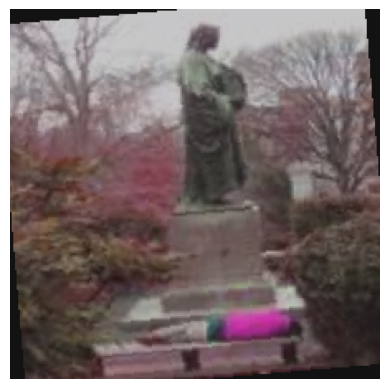

In [ ]:
index = 2
print("한 데이터 양식",train_data[index])
print("한 데이터 사진",train_data[index][0].shape)
print("한 데이터 라벨",train_data[index][1])

image_tensor = train_data[index][0].clone()
image_np = image_tensor.numpy()

# 채널 순서를 (높이, 너비, 채널)로 변경
image_np = image_np.transpose(1, 2, 0)

# 이미지 출력
plt.imshow(image_np)
plt.axis('off')  # 축 숨기기
plt.show()



In [ ]:
import warnings
import matplotlib.pyplot as plt

bad_list = [11, 13, 19, 10]
bad_words = ['tool', 'electronic', 'fumiture', 'container']
bad_dict = dict(zip(bad_list, bad_words))

good_list = [18, 6, 8, 16]
good_words = ['GeologicalFormation', 'Building', 'Food', 'Mammal']
good_dict = dict(zip(good_list, good_words))

In [ ]:
# 이선우 전처리
import warnings
import matplotlib.pyplot as plt

# 모든 경고 무시
warnings.filterwarnings("ignore")

# 이미지 시각화 함수
def display_images(image_list, title, label_dict, num_images=40, width=5):
    rows = (num_images + width - 1) // width  # 필요한 행 수 계산
    fig, axes = plt.subplots(rows, width, figsize=(15, 3 * rows))  # 행 수에 따라 크기 조정
    fig.suptitle(title)

    # 필요한 개수만큼 이미지 출력
    for i, (img, label) in enumerate(image_list[:num_images]):
        ax = axes[i // width, i % width]  # 위치 계산

        # 이미지 데이터 클리핑 (0-1 범위)
        img = img.clamp(0, 1)  # 0과 1 사이로 클리핑 (0-1 범위로 정규화된 경우)
        # 또는
        # img = img.clip(0, 255)  # 0-255 범위로 클리핑 (정수형 데이터의 경우)

        ax.imshow(img.permute(1, 2, 0))  # (C, H, W) -> (H, W, C) 형식으로 변경
        ax.axis('off')
        ax.set_title(label_dict[label])  # 딕셔너리에서 라벨에 해당하는 단어 가져오기

    # 남은 서브플롯은 비워두기
    for j in range(i + 1, rows * width):
        ax = axes[j // width, j % width]
        ax.axis('off')

    plt.show()

# 조건에 맞는 이미지 필터링 함수 (랜덤 시작점 및 순환 방식)
def filter_images_by_label(dataset, label_list, num_images):
    filtered_images = []
    count_per_label = {label: 0 for label in label_list}
    remaining_labels = set(label_list)

    # 무작위 시작점 선택
    start_index = random.randint(0, len(dataset) - 1)
    dataset_size = len(dataset)

    # 데이터셋을 시작 인덱스부터 순환
    idx = start_index
    while remaining_labels:
        img, label = dataset[idx]

        # 라벨이 label_list에 있고, 아직 num_images에 도달하지 않았다면 추가
        if label in remaining_labels:
            if count_per_label[label] < num_images:
                filtered_images.append((img, label))
                count_per_label[label] += 1

            # 해당 라벨이 충분한 이미지 수를 얻었으면 제거
            if count_per_label[label] >= num_images:
                remaining_labels.remove(label)

        # 인덱스 증가, 끝에 도달하면 처음으로 돌아감
        idx = (idx + 1) % dataset_size

    return filtered_images
number = 14
width = 7
# good과 bad 리스트에 따라 이미지 필터링
good_images = filter_images_by_label(train_data, good_list, number)
bad_images = filter_images_by_label(train_data, bad_list, number)

# good 이미지 내에서 라벨 기준으로 정렬
good_images_sorted = sorted(good_images, key=lambda x: x[1])  # 라벨 기준으로 정렬

# bad 이미지 내에서 라벨 기준으로 정렬
bad_images_sorted = sorted(bad_images, key=lambda x: x[1])  # 라벨 기준으로 정렬

# good과 bad 이미지 출력
display_images(good_images_sorted, "Good Images", good_dict, num_images=4 * number, width=width)  # 넓이 5
print("-" * 100)
display_images(bad_images_sorted, "Bad Images", bad_dict, num_images=4 * number, width=width)  # 넓이 5


Output hidden; open in https://colab.research.google.com to view.

# Model

In [ ]:
def save_model(model, save_path):
    """
    모델의 상태를 저장하는 함수.

    Parameters:
    model (torch.nn.Module): 저장할 PyTorch 모델
    save_path (str): 모델을 저장할 경로
    """
    torch.save(model.state_dict(), save_path)
    print(f'Model saved to {save_path}')

def load_model(model, load_path):
    """
    저장된 모델의 상태를 불러오는 함수.

    Parameters:
    model (torch.nn.Module): 불러올 PyTorch 모델 인스턴스
    load_path (str): 모델을 불러올 경로
    """
    model.load_state_dict(torch.load(load_path))
    model.eval()  # 평가 모드로 전환
    print(f'Model loaded from {load_path}')


### 레즈넷

In [ ]:
def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation,
    )


def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)
class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError("BasicBlock only supports groups=1 and base_width=64")
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition" https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.0)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    def __init__(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        layers: List[int],
        num_classes: int = 1000,
        zero_init_residual: bool = False,
        groups: int = 1,
        width_per_group: int = 64,
        replace_stride_with_dilation: Optional[List[bool]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        # _log_api_usage_once(self)
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError(
                "replace_stride_with_dilation should be None "
                f"or a 3-element tuple, got {replace_stride_with_dilation}"
            )
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck) and m.bn3.weight is not None:
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(m, BasicBlock) and m.bn2.weight is not None:
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]

    def _make_layer(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        planes: int,
        blocks: int,
        stride: int = 1,
        dilate: bool = False,
    ) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(
                self.inplanes, planes, stride, downsample, self.groups, self.base_width, previous_dilation, norm_layer
            )
        )
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                    norm_layer=norm_layer,
                )
            )

        return nn.Sequential(*layers)

    def _forward_impl(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)


In [ ]:
def _resnet(
    block: Type[Union[BasicBlock, Bottleneck]],
    layers: List[int],
    weights: Optional[WeightsEnum],
    progress: bool,
    **kwargs: Any,
) -> ResNet:
    if weights is not None:
        _ovewrite_named_param(kwargs, "num_classes", len(weights.meta["categories"]))

    model = ResNet(block, layers, **kwargs)

    if weights is not None:
        model.load_state_dict(weights.get_state_dict(progress=progress, check_hash=True))

    return model


_COMMON_META = {
    "min_size": (1, 1),
    "categories": _IMAGENET_CATEGORIES,
}

In [ ]:
def resnet18(*, weights: Optional[ResNet18_Weights] = None, progress: bool = True, **kwargs: Any) -> ResNet:
    return _resnet(BasicBlock, [2, 2, 2, 2], weights, progress, **kwargs)


def resnet34(*, weights: Optional[ResNet34_Weights] = None, progress: bool = True, **kwargs: Any) -> ResNet:
    return _resnet(BasicBlock, [3, 4, 6, 3], weights, progress, **kwargs)


def resnet50(*, weights: Optional[ResNet50_Weights] = None, progress: bool = True, **kwargs: Any) -> ResNet:
    return _resnet(Bottleneck, [3, 4, 6, 3], weights, progress, **kwargs)


def resnet101(*, weights: Optional[ResNet101_Weights] = None, progress: bool = True, **kwargs: Any) -> ResNet:
    return _resnet(Bottleneck, [3, 4, 23, 3], weights, progress, **kwargs)


def resnet152(*, weights: Optional[ResNet152_Weights] = None, progress: bool = True, **kwargs: Any) -> ResNet:
    return _resnet(Bottleneck, [3, 8, 36, 3], weights, progress, **kwargs)


In [ ]:
model_res_18 = ResNet(BasicBlock,[2, 2, 2, 2],21)

In [ ]:
model_res_34 = ResNet(BasicBlock,[3, 4, 6, 3],21)

In [ ]:
model_res_50 = ResNet(Bottleneck,[3, 4, 6, 3],21)

In [ ]:
model_res_101 = ResNet(Bottleneck,[3, 4, 23, 3],21)

In [ ]:
model_res_152 = ResNet(Bottleneck,[3, 8, 36, 3],21)

In [ ]:
myModel_res_ = ResNet(Bottleneck,[3, 8, 36, 3],21)

In [ ]:
# 1. Pretrained ResNet-50 모델 가져오기
resnet50 = models.resnet50(pretrained=True)

# 2. 기존의 FC 레이어를 3겹으로 확장
# 마지막 레이어의 입력 크기를 가져옵니다.
in_features = resnet50.fc.in_features

# 3겹의 FC 레이어로 구성된 새로운 head 정의
resnet50.fc = nn.Sequential(
    nn.Linear(in_features, 512),  # 첫 번째 FC 레이어
    nn.ReLU(),                    # 활성화 함수
    nn.Dropout(0.5),              # 드롭아웃 (정규화)
    nn.Linear(512, 256),          # 두 번째 FC 레이어
    nn.ReLU(),                    # 활성화 함수
    nn.Dropout(0.5),              # 드롭아웃 (정규화)
    nn.Linear(256, 21)            # 세 번째 FC 레이어: 최종 출력 (21개의 클래스)
)

# 3. 하위 레이어는 고정하고 상위 레이어만 학습 가능하게 설정
for param in resnet50.parameters():
    param.requires_grad = False  # 모든 레이어를 고정

# 마지막 FC 부분만 학습 가능하게 설정
for param in resnet50.fc.parameters():
    param.requires_grad = True

# 모델 출력 확인
print(resnet50)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 161MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# class ResNet(nn.Module):
#     def __init__(
#         self,
#  a       block: Type[Union[BasicBlock, Bottleneck]],
#  a       layers: List[int],
#  a       num_classes: int = 1000,
#         zero_init_residual: bool = False,
#         groups: int = 1,
#         width_per_group: int = 64,
#         replace_stride_with_dilation: Optional[List[bool]] = None,
#         norm_layer: Optional[Callable[..., nn.Module]] = None,
#     ) -> None:

In [ ]:
model = model_res_50
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## 비전트랜스포머

In [ ]:
!pip install --upgrade timm

In [ ]:
from timm import create_model  # timm 라이브러리에서 모델을 불러옴
import torch.nn as nn  # nn 모듈 가져오기

# 'deit_tiny_patch16_224' 모델 가져오기 (더 작은 모델 사용)
model = create_model('deit_tiny_patch16_224', pretrained=True)  # 사전 훈련된 모델 사용

# 2. 기존의 헤드 레이어를 21로 변경
model.head = nn.Linear(model.head.in_features, 21)  # 출력 레이어를 21로 변경

# 3. 모든 레이어가 학습 가능하도록 설정
for param in model.parameters():
    param.requires_grad = True

# 모델 출력 확인
print(model)


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=192, out_features=576, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=192, out_features=192, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=192, out_features=768, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity()


### 레즈넷 끝

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self, class_num=10):
        super(NeuralNetwork, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 7, padding=3)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 7, padding=3)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, 7, padding=3)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, 7, padding=3)
        self.bn4 = nn.BatchNorm2d(256)

        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, class_num)
        self.ReLU = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.ReLU(self.bn1(self.conv1(x))))
        x = self.pool(self.ReLU(self.bn2(self.conv2(x))))

        x = self.pool(self.ReLU(self.bn3(self.conv3(x))))
        x = self.pool(self.ReLU(self.bn4(self.conv4(x))))

        x = x.view(-1, 256 * 8 * 8)
        x = self.ReLU(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
model = NeuralNetwork(class_num=21)
print(model)

NeuralNetwork(
  (conv1): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=21, bias=True)
  (ReLU): ReLU()
)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

num_epochs = 200
model_save_path = '/content/updata_data_vt_16_train_model_{}.pth'
total_step = len(train_loader)
for epoch in range(num_epochs):
    total_loss = 0

    pbar = tqdm(enumerate(train_loader), total=len(train_loader))

    for i, (images, labels) in pbar:
        # print(images.shape)
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        pbar.set_description(f'Epoch [{epoch+1}/{num_epochs}], Loss: {round(total_loss / (i+1),4)}')


    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print(f'Accuracy of the model on the test images: {100 * correct / total} %')
    # 에폭이 25의 배수일 때 모델 저장
    if (epoch + 1) % 25 == 0:
        save_model(model, model_save_path.format(epoch + 1))  # 모델 저장
        print('모델 세이브 ',epoch)

Epoch [1/200], Loss: 2.3718: 100%|██████████| 517/517 [11:38<00:00,  1.35s/it]


Accuracy of the model on the test images: 43.006802721088434 %


Epoch [2/200], Loss: 1.7729: 100%|██████████| 517/517 [11:43<00:00,  1.36s/it]


Accuracy of the model on the test images: 52.63945578231292 %


Epoch [3/200], Loss: 1.5435: 100%|██████████| 517/517 [11:44<00:00,  1.36s/it]


Accuracy of the model on the test images: 55.97278911564626 %


Epoch [4/200], Loss: 1.4272: 100%|██████████| 517/517 [11:40<00:00,  1.35s/it]


Accuracy of the model on the test images: 57.91836734693877 %


Epoch [5/200], Loss: 1.3296: 100%|██████████| 517/517 [11:38<00:00,  1.35s/it]


Accuracy of the model on the test images: 59.74149659863946 %


Epoch [6/200], Loss: 1.2623: 100%|██████████| 517/517 [11:40<00:00,  1.35s/it]


Accuracy of the model on the test images: 60.6530612244898 %


Epoch [7/200], Loss: 1.2083: 100%|██████████| 517/517 [11:36<00:00,  1.35s/it]


Accuracy of the model on the test images: 62.25850340136054 %


Epoch [8/200], Loss: 1.157: 100%|██████████| 517/517 [11:32<00:00,  1.34s/it]


Accuracy of the model on the test images: 62.326530612244895 %


Epoch [9/200], Loss: 1.1153: 100%|██████████| 517/517 [11:34<00:00,  1.34s/it]


Accuracy of the model on the test images: 63.78231292517007 %


Epoch [10/200], Loss: 1.0792: 100%|██████████| 517/517 [11:33<00:00,  1.34s/it]


Accuracy of the model on the test images: 64.17687074829932 %


Epoch [11/200], Loss: 1.0481: 100%|██████████| 517/517 [11:32<00:00,  1.34s/it]


Accuracy of the model on the test images: 64.12244897959184 %


Epoch [12/200], Loss: 1.0196: 100%|██████████| 517/517 [11:33<00:00,  1.34s/it]


Accuracy of the model on the test images: 63.98639455782313 %


Epoch [13/200], Loss: 0.9913: 100%|██████████| 517/517 [11:30<00:00,  1.34s/it]


Accuracy of the model on the test images: 66.66666666666667 %


Epoch [14/200], Loss: 0.9709: 100%|██████████| 517/517 [11:28<00:00,  1.33s/it]


Accuracy of the model on the test images: 63.70068027210884 %


Epoch [15/200], Loss: 0.9453: 100%|██████████| 517/517 [11:28<00:00,  1.33s/it]


Accuracy of the model on the test images: 66.92517006802721 %


Epoch [16/200], Loss: 0.9164: 100%|██████████| 517/517 [11:37<00:00,  1.35s/it]


Accuracy of the model on the test images: 67.0204081632653 %


Epoch [17/200], Loss: 0.9014: 100%|██████████| 517/517 [11:26<00:00,  1.33s/it]


Accuracy of the model on the test images: 66.05442176870748 %


Epoch [18/200], Loss: 0.8764: 100%|██████████| 517/517 [11:24<00:00,  1.32s/it]


Accuracy of the model on the test images: 66.65306122448979 %


Epoch [19/200], Loss: 0.8567: 100%|██████████| 517/517 [11:26<00:00,  1.33s/it]


Accuracy of the model on the test images: 67.3061224489796 %


Epoch [20/200], Loss: 0.8401: 100%|██████████| 517/517 [11:29<00:00,  1.33s/it]


Accuracy of the model on the test images: 67.78231292517007 %


Epoch [21/200], Loss: 0.8255: 100%|██████████| 517/517 [11:31<00:00,  1.34s/it]


Accuracy of the model on the test images: 67.37414965986395 %


Epoch [22/200], Loss: 0.8142: 100%|██████████| 517/517 [11:27<00:00,  1.33s/it]


Accuracy of the model on the test images: 68.6938775510204 %


Epoch [23/200], Loss: 0.7907: 100%|██████████| 517/517 [11:29<00:00,  1.33s/it]


Accuracy of the model on the test images: 67.55102040816327 %


Epoch [24/200], Loss: 0.7697: 100%|██████████| 517/517 [11:29<00:00,  1.33s/it]


Accuracy of the model on the test images: 67.72789115646259 %


Epoch [25/200], Loss: 0.757: 100%|██████████| 517/517 [11:31<00:00,  1.34s/it]


Accuracy of the model on the test images: 68.3265306122449 %
Model saved to /content/updata_data_vt_16_train_model_25.pth
모델 세이브  24


Epoch [26/200], Loss: 0.7094:  52%|█████▏    | 267/517 [05:55<05:33,  1.33s/it]


KeyboardInterrupt: 

# Evaluation

## 레즈넷 50 전처리 후 결과

In [ ]:
data_path = "Kaggle02"
with open(f"{data_path}/class_name.json") as f:
    class_name = json.load(f)
print(class_name)

class_name = [k for k, v in class_name.items()]
print(class_name)

{'Fish': 0, 'Plant': 1, 'Utensil': 2, 'Insect': 3, 'Appliance': 4, 'Bird': 5, 'Building': 6, 'Clothing': 7, 'Food': 8, 'Structure': 9, 'Container': 10, 'Tool': 11, 'SportsEquipment': 12, 'Electronic': 13, 'Reptile': 14, 'Weapon': 15, 'Mammal': 16, 'MusicalInstrument': 17, 'GeologicalFormation': 18, 'Furniture': 19, 'Vehicle': 20}
['Fish', 'Plant', 'Utensil', 'Insect', 'Appliance', 'Bird', 'Building', 'Clothing', 'Food', 'Structure', 'Container', 'Tool', 'SportsEquipment', 'Electronic', 'Reptile', 'Weapon', 'Mammal', 'MusicalInstrument', 'GeologicalFormation', 'Furniture', 'Vehicle']


Accuracy of Fish : 57.06 %
Accuracy of Plant : 51.97 %
Accuracy of Utensil : 40.00 %
Accuracy of Insect : 62.60 %
Accuracy of Appliance : 47.46 %
Accuracy of Bird : 62.61 %
Accuracy of Building : 74.86 %
Accuracy of Clothing : 47.45 %
Accuracy of Food : 75.62 %
Accuracy of Structure : 42.78 %
Accuracy of Container : 41.96 %
Accuracy of Tool : 24.92 %
Accuracy of SportsEquipment : 41.80 %
Accuracy of Electronic : 31.65 %
Accuracy of Reptile : 63.35 %
Accuracy of Weapon : 45.95 %
Accuracy of Mammal : 65.36 %
Accuracy of MusicalInstrument : 43.92 %
Accuracy of GeologicalFormation : 79.62 %
Accuracy of Furniture : 30.99 %
Accuracy of Vehicle : 49.71 %
Average Loss of Fish : 1.8689
Average Loss of Plant : 1.8886
Average Loss of Utensil : 1.8706
Average Loss of Insect : 1.8889
Average Loss of Appliance : 1.8829
Average Loss of Bird : 1.8958
Average Loss of Building : 1.8784
Average Loss of Clothing : 1.8702
Average Loss of Food : 1.8794
Average Loss of Structure : 1.8863
Average Loss of Cont

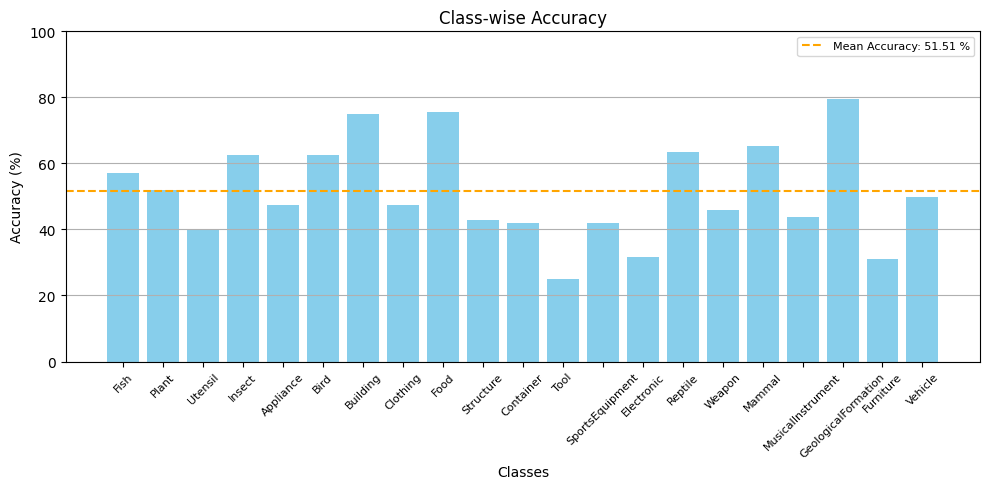

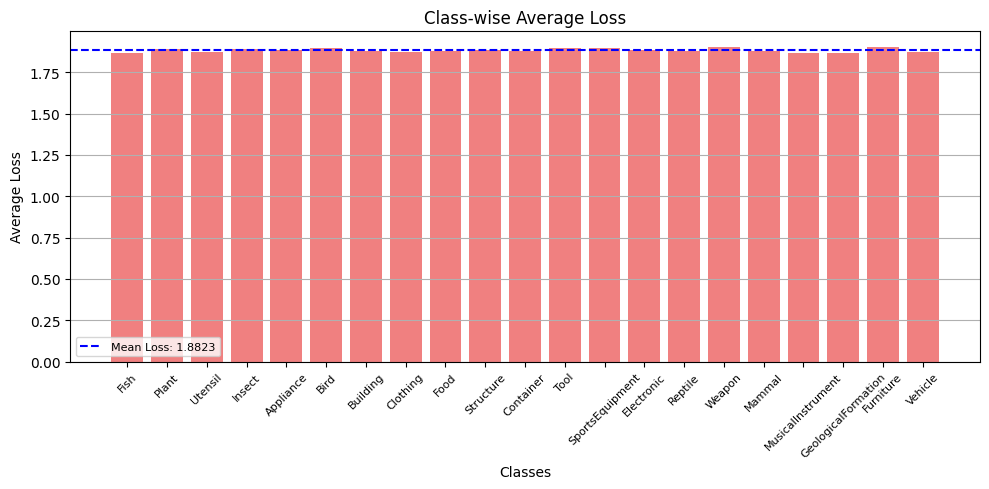

In [ ]:
# 클래스별 정확도 및 총 개수 초기화
class_correct = list(0. for _ in range(len(class_name)))
class_total = list(0. for _ in range(len(class_name)))

# 클래스별 손실 초기화
class_loss = list(0. for _ in range(len(class_name)))
class_count = list(0. for _ in range(len(class_name)))

# 손실 함수 정의
criterion = nn.CrossEntropyLoss()

# 모델 평가
with torch.no_grad():
    total_loss = 0.0  # 전체 손실 초기화
    total_samples = 0  # 전체 샘플 수 초기화
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)

        # 손실 계산
        loss = criterion(outputs, labels)
        total_loss += loss.item() * labels.size(0)  # 전체 손실에 샘플 수를 곱하여 추가
        total_samples += labels.size(0)  # 전체 샘플 수 증가

        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()

        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
            class_loss[label] += loss.item()  # 손실 누적
            class_count[label] += 1  # 클래스별 샘플 수 증가

# 클래스별 정확도 출력
accuracies = []
for i in range(len(class_name)):
    accuracy = 100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0.0
    accuracies.append(accuracy)
    print(f'Accuracy of {class_name[i]} : {accuracy:.2f} %')

# 클래스별 평균 손실 계산
average_losses = []
for i in range(len(class_name)):
    average_loss = class_loss[i] / class_count[i] if class_count[i] > 0 else 0.0
    average_losses.append(average_loss)
    print(f'Average Loss of {class_name[i]} : {average_loss:.4f}')

# 전체 평균 손실 계산
mean_loss = total_loss / total_samples if total_samples > 0 else 0.0
print(f'Mean Loss: {mean_loss:.4f}')

# 평균 정확도 계산
mean_accuracy = sum(accuracies) / len(accuracies)
print(f'Mean Accuracy: {mean_accuracy:.2f} %')

# 정확도 히스토그램
plt.figure(figsize=(10, 5))
plt.bar(class_name, accuracies, color='skyblue')
plt.axhline(y=mean_accuracy, color='orange', linestyle='--', label=f'Mean Accuracy: {mean_accuracy:.2f} %')
plt.xlabel('Classes', fontsize=10)  # X축 레이블 글자 크기 조정
plt.ylabel('Accuracy (%)', fontsize=10)  # Y축 레이블 글자 크기 조정
plt.title('Class-wise Accuracy', fontsize=12)  # 제목 글자 크기 조정
plt.xticks(rotation=45, fontsize=8)  # X축 눈금 글자 크기 조정
plt.ylim(0, 100)
plt.grid(axis='y')
plt.legend(fontsize=8)  # 범례 글자 크기 조정
plt.tight_layout()
plt.show()  # 첫 번째 플롯 표시

# 손실 히스토그램
plt.figure(figsize=(10, 5))
plt.bar(class_name, average_losses, color='lightcoral')
plt.axhline(y=mean_loss, color='blue', linestyle='--', label=f'Mean Loss: {mean_loss:.4f}')  # 평균 손실 추가
plt.xlabel('Classes', fontsize=10)  # X축 레이블 글자 크기 조정
plt.ylabel('Average Loss', fontsize=10)  # Y축 레이블 글자 크기 조정
plt.title('Class-wise Average Loss', fontsize=12)  # 제목 글자 크기 조정
plt.xticks(rotation=45, fontsize=8)  # X축 눈금 글자 크기 조정
plt.grid(axis='y')
plt.legend(fontsize=8)  # 범례 글자 크기 조정
plt.tight_layout()
plt.show()  # 두 번째 플롯 표시


## 레즈넷 50 전처리 안한 결과

Accuracy of Fish : 55.30 %
Accuracy of Plant : 53.42 %
Accuracy of Utensil : 22.14 %
Accuracy of Insect : 43.70 %
Accuracy of Appliance : 27.08 %
Accuracy of Bird : 55.17 %
Accuracy of Building : 64.26 %
Accuracy of Clothing : 37.87 %
Accuracy of Food : 59.49 %
Accuracy of Structure : 37.05 %
Accuracy of Container : 29.34 %
Accuracy of Tool : 22.87 %
Accuracy of SportsEquipment : 37.46 %
Accuracy of Electronic : 22.95 %
Accuracy of Reptile : 39.67 %
Accuracy of Weapon : 35.67 %
Accuracy of Mammal : 60.22 %
Accuracy of MusicalInstrument : 22.47 %
Accuracy of GeologicalFormation : 59.06 %
Accuracy of Furniture : 30.21 %
Accuracy of Vehicle : 54.82 %
Average Loss of Fish : 2.8476
Average Loss of Plant : 2.8597
Average Loss of Utensil : 2.8543
Average Loss of Insect : 2.8897
Average Loss of Appliance : 2.8686
Average Loss of Bird : 2.8636
Average Loss of Building : 2.8643
Average Loss of Clothing : 2.8718
Average Loss of Food : 2.8619
Average Loss of Structure : 2.8634
Average Loss of Cont

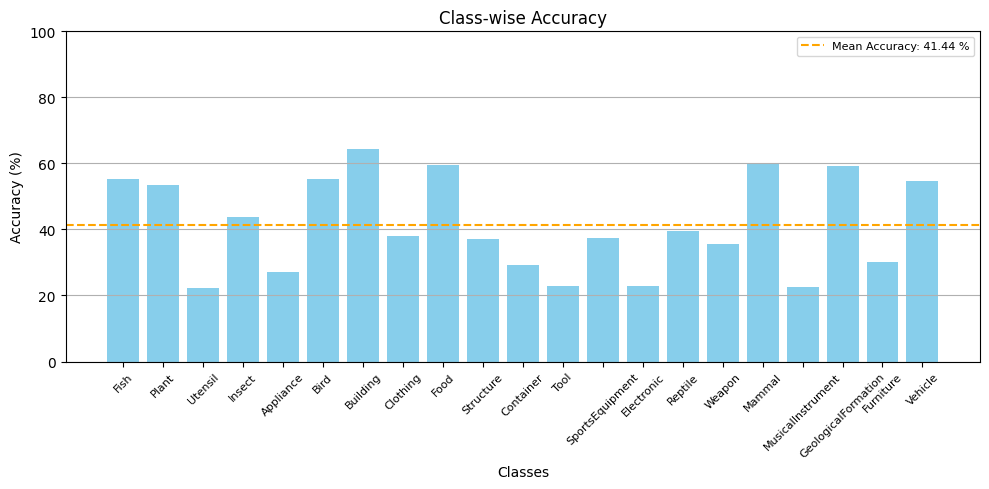

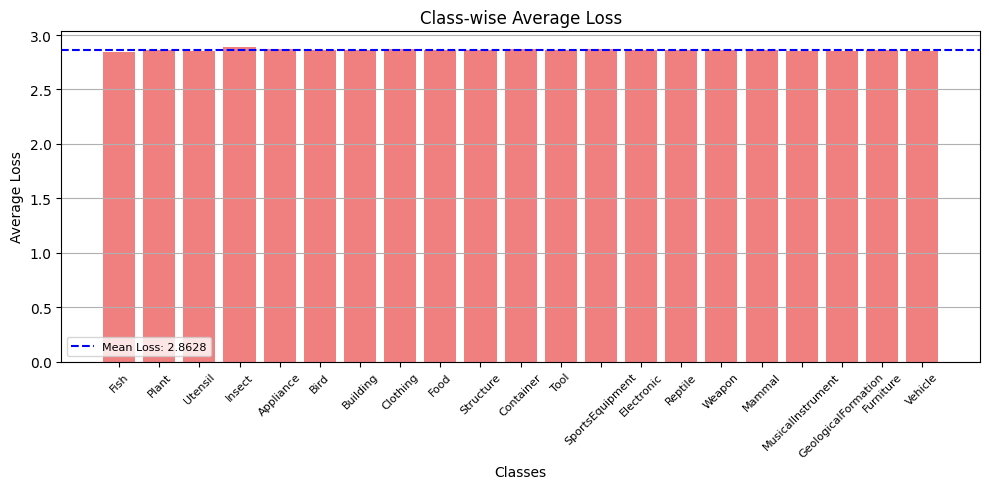

In [ ]:
# 클래스별 정확도 및 총 개수 초기화
class_correct = list(0. for _ in range(len(class_name)))
class_total = list(0. for _ in range(len(class_name)))

# 클래스별 손실 초기화
class_loss = list(0. for _ in range(len(class_name)))
class_count = list(0. for _ in range(len(class_name)))

# 손실 함수 정의
criterion = nn.CrossEntropyLoss()

# 모델 평가
with torch.no_grad():
    total_loss = 0.0  # 전체 손실 초기화
    total_samples = 0  # 전체 샘플 수 초기화
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)

        # 손실 계산
        loss = criterion(outputs, labels)
        total_loss += loss.item() * labels.size(0)  # 전체 손실에 샘플 수를 곱하여 추가
        total_samples += labels.size(0)  # 전체 샘플 수 증가

        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()

        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
            class_loss[label] += loss.item()  # 손실 누적
            class_count[label] += 1  # 클래스별 샘플 수 증가

# 클래스별 정확도 출력
accuracies = []
for i in range(len(class_name)):
    accuracy = 100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0.0
    accuracies.append(accuracy)
    print(f'Accuracy of {class_name[i]} : {accuracy:.2f} %')

# 클래스별 평균 손실 계산
average_losses = []
for i in range(len(class_name)):
    average_loss = class_loss[i] / class_count[i] if class_count[i] > 0 else 0.0
    average_losses.append(average_loss)
    print(f'Average Loss of {class_name[i]} : {average_loss:.4f}')

# 전체 평균 손실 계산
mean_loss = total_loss / total_samples if total_samples > 0 else 0.0
print(f'Mean Loss: {mean_loss:.4f}')

# 평균 정확도 계산
mean_accuracy = sum(accuracies) / len(accuracies)
print(f'Mean Accuracy: {mean_accuracy:.2f} %')

# 정확도 히스토그램
plt.figure(figsize=(10, 5))
plt.bar(class_name, accuracies, color='skyblue')
plt.axhline(y=mean_accuracy, color='orange', linestyle='--', label=f'Mean Accuracy: {mean_accuracy:.2f} %')
plt.xlabel('Classes', fontsize=10)  # X축 레이블 글자 크기 조정
plt.ylabel('Accuracy (%)', fontsize=10)  # Y축 레이블 글자 크기 조정
plt.title('Class-wise Accuracy', fontsize=12)  # 제목 글자 크기 조정
plt.xticks(rotation=45, fontsize=8)  # X축 눈금 글자 크기 조정
plt.ylim(0, 100)
plt.grid(axis='y')
plt.legend(fontsize=8)  # 범례 글자 크기 조정
plt.tight_layout()
plt.show()  # 첫 번째 플롯 표시

# 손실 히스토그램
plt.figure(figsize=(10, 5))
plt.bar(class_name, average_losses, color='lightcoral')
plt.axhline(y=mean_loss, color='blue', linestyle='--', label=f'Mean Loss: {mean_loss:.4f}')  # 평균 손실 추가
plt.xlabel('Classes', fontsize=10)  # X축 레이블 글자 크기 조정
plt.ylabel('Average Loss', fontsize=10)  # Y축 레이블 글자 크기 조정
plt.title('Class-wise Average Loss', fontsize=12)  # 제목 글자 크기 조정
plt.xticks(rotation=45, fontsize=8)  # X축 눈금 글자 크기 조정
plt.grid(axis='y')
plt.legend(fontsize=8)  # 범례 글자 크기 조정
plt.tight_layout()
plt.show()  # 두 번째 플롯 표시


## 레즈넷 50 사이즈 224 전처리 안한 결과

Accuracy of Fish : 47.51 %
Accuracy of Plant : 43.70 %
Accuracy of Utensil : 39.76 %
Accuracy of Insect : 44.54 %
Accuracy of Appliance : 45.14 %
Accuracy of Bird : 51.30 %
Accuracy of Building : 73.14 %
Accuracy of Clothing : 44.20 %
Accuracy of Food : 72.42 %
Accuracy of Structure : 43.92 %
Accuracy of Container : 29.15 %
Accuracy of Tool : 21.58 %
Accuracy of SportsEquipment : 32.57 %
Accuracy of Electronic : 43.98 %
Accuracy of Reptile : 63.64 %
Accuracy of Weapon : 39.00 %
Accuracy of Mammal : 77.62 %
Accuracy of MusicalInstrument : 40.28 %
Accuracy of GeologicalFormation : 76.71 %
Accuracy of Furniture : 35.26 %
Accuracy of Vehicle : 50.74 %
Average Loss of Fish : 1.7076
Average Loss of Plant : 1.7190
Average Loss of Utensil : 1.6934
Average Loss of Insect : 1.6953
Average Loss of Appliance : 1.7208
Average Loss of Bird : 1.6946
Average Loss of Building : 1.6943
Average Loss of Clothing : 1.7082
Average Loss of Food : 1.6867
Average Loss of Structure : 1.7210
Average Loss of Cont

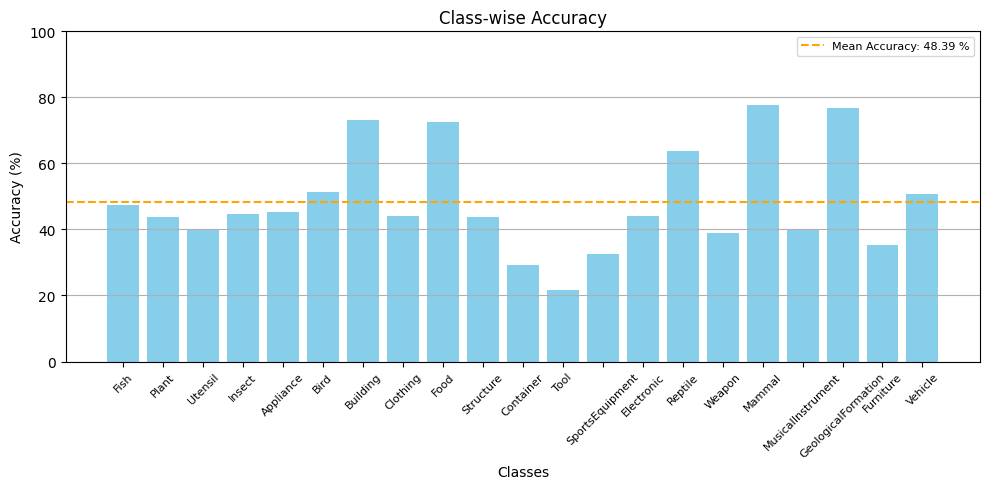

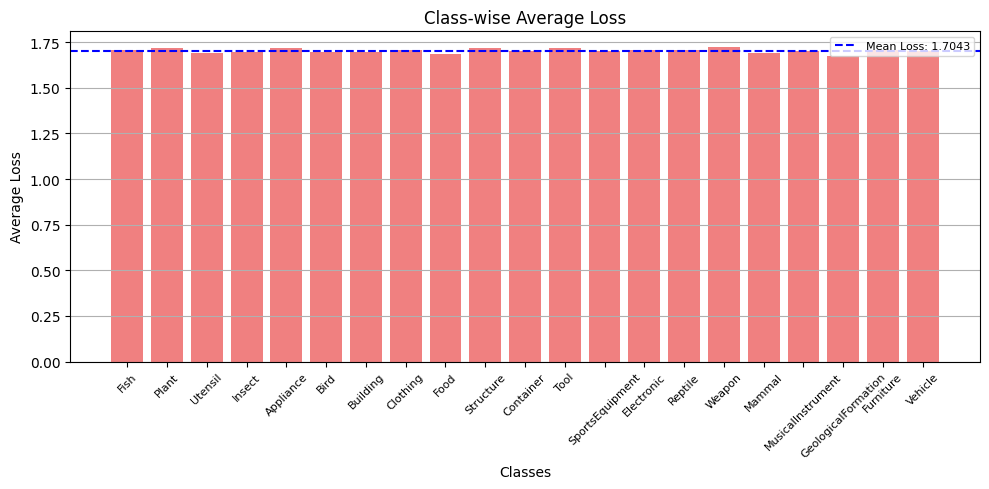

In [ ]:
# 클래스별 정확도 및 총 개수 초기화
class_correct = list(0. for _ in range(len(class_name)))
class_total = list(0. for _ in range(len(class_name)))

# 클래스별 손실 초기화
class_loss = list(0. for _ in range(len(class_name)))
class_count = list(0. for _ in range(len(class_name)))

# 손실 함수 정의
criterion = nn.CrossEntropyLoss()

# 모델 평가
with torch.no_grad():
    total_loss = 0.0  # 전체 손실 초기화
    total_samples = 0  # 전체 샘플 수 초기화
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)

        # 손실 계산
        loss = criterion(outputs, labels)
        total_loss += loss.item() * labels.size(0)  # 전체 손실에 샘플 수를 곱하여 추가
        total_samples += labels.size(0)  # 전체 샘플 수 증가

        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()

        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
            class_loss[label] += loss.item()  # 손실 누적
            class_count[label] += 1  # 클래스별 샘플 수 증가

# 클래스별 정확도 출력
accuracies = []
for i in range(len(class_name)):
    accuracy = 100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0.0
    accuracies.append(accuracy)
    print(f'Accuracy of {class_name[i]} : {accuracy:.2f} %')

# 클래스별 평균 손실 계산
average_losses = []
for i in range(len(class_name)):
    average_loss = class_loss[i] / class_count[i] if class_count[i] > 0 else 0.0
    average_losses.append(average_loss)
    print(f'Average Loss of {class_name[i]} : {average_loss:.4f}')

# 전체 평균 손실 계산
mean_loss = total_loss / total_samples if total_samples > 0 else 0.0
print(f'Mean Loss: {mean_loss:.4f}')

# 평균 정확도 계산
mean_accuracy = sum(accuracies) / len(accuracies)
print(f'Mean Accuracy: {mean_accuracy:.2f} %')

# 정확도 히스토그램
plt.figure(figsize=(10, 5))
plt.bar(class_name, accuracies, color='skyblue')
plt.axhline(y=mean_accuracy, color='orange', linestyle='--', label=f'Mean Accuracy: {mean_accuracy:.2f} %')
plt.xlabel('Classes', fontsize=10)  # X축 레이블 글자 크기 조정
plt.ylabel('Accuracy (%)', fontsize=10)  # Y축 레이블 글자 크기 조정
plt.title('Class-wise Accuracy', fontsize=12)  # 제목 글자 크기 조정
plt.xticks(rotation=45, fontsize=8)  # X축 눈금 글자 크기 조정
plt.ylim(0, 100)
plt.grid(axis='y')
plt.legend(fontsize=8)  # 범례 글자 크기 조정
plt.tight_layout()
plt.show()  # 첫 번째 플롯 표시

# 손실 히스토그램
plt.figure(figsize=(10, 5))
plt.bar(class_name, average_losses, color='lightcoral')
plt.axhline(y=mean_loss, color='blue', linestyle='--', label=f'Mean Loss: {mean_loss:.4f}')  # 평균 손실 추가
plt.xlabel('Classes', fontsize=10)  # X축 레이블 글자 크기 조정
plt.ylabel('Average Loss', fontsize=10)  # Y축 레이블 글자 크기 조정
plt.title('Class-wise Average Loss', fontsize=12)  # 제목 글자 크기 조정
plt.xticks(rotation=45, fontsize=8)  # X축 눈금 글자 크기 조정
plt.grid(axis='y')
plt.legend(fontsize=8)  # 범례 글자 크기 조정
plt.tight_layout()
plt.show()  # 두 번째 플롯 표시


## 비전 트랜스포머


Accuracy of Fish : 57.52 %
Accuracy of Plant : 61.30 %
Accuracy of Utensil : 49.85 %
Accuracy of Insect : 70.27 %
Accuracy of Appliance : 54.44 %
Accuracy of Bird : 61.21 %
Accuracy of Building : 74.25 %
Accuracy of Clothing : 50.87 %
Accuracy of Food : 57.87 %
Accuracy of Structure : 56.35 %
Accuracy of Container : 40.92 %
Accuracy of Tool : 31.98 %
Accuracy of SportsEquipment : 36.52 %
Accuracy of Electronic : 42.15 %
Accuracy of Reptile : 56.92 %
Accuracy of Weapon : 49.58 %
Accuracy of Mammal : 76.88 %
Accuracy of MusicalInstrument : 36.86 %
Accuracy of GeologicalFormation : 86.08 %
Accuracy of Furniture : 48.93 %
Accuracy of Vehicle : 53.33 %
Average Loss of Fish : 1.8564
Average Loss of Plant : 1.8440
Average Loss of Utensil : 1.8368
Average Loss of Insect : 1.8504
Average Loss of Appliance : 1.8454
Average Loss of Bird : 1.8455
Average Loss of Building : 1.7928
Average Loss of Clothing : 1.8336
Average Loss of Food : 1.8321
Average Loss of Structure : 1.8783
Average Loss of Cont

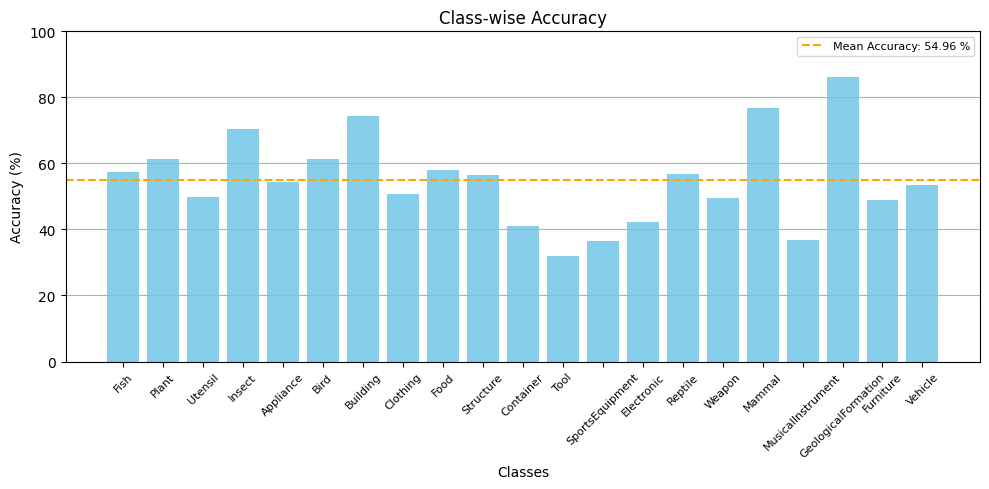

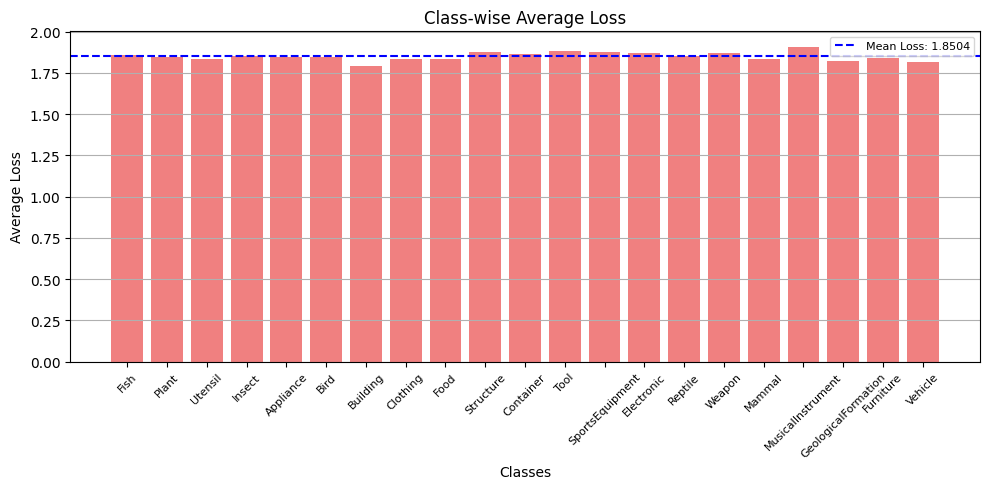

In [ ]:
# 클래스별 정확도 및 총 개수 초기화
class_correct = list(0. for _ in range(len(class_name)))
class_total = list(0. for _ in range(len(class_name)))

# 클래스별 손실 초기화
class_loss = list(0. for _ in range(len(class_name)))
class_count = list(0. for _ in range(len(class_name)))

# 손실 함수 정의
criterion = nn.CrossEntropyLoss()

# 모델 평가
with torch.no_grad():
    total_loss = 0.0  # 전체 손실 초기화
    total_samples = 0  # 전체 샘플 수 초기화
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)

        # 손실 계산
        loss = criterion(outputs, labels)
        total_loss += loss.item() * labels.size(0)  # 전체 손실에 샘플 수를 곱하여 추가
        total_samples += labels.size(0)  # 전체 샘플 수 증가

        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()

        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
            class_loss[label] += loss.item()  # 손실 누적
            class_count[label] += 1  # 클래스별 샘플 수 증가

# 클래스별 정확도 출력
accuracies = []
for i in range(len(class_name)):
    accuracy = 100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0.0
    accuracies.append(accuracy)
    print(f'Accuracy of {class_name[i]} : {accuracy:.2f} %')

# 클래스별 평균 손실 계산
average_losses = []
for i in range(len(class_name)):
    average_loss = class_loss[i] / class_count[i] if class_count[i] > 0 else 0.0
    average_losses.append(average_loss)
    print(f'Average Loss of {class_name[i]} : {average_loss:.4f}')

# 전체 평균 손실 계산
mean_loss = total_loss / total_samples if total_samples > 0 else 0.0
print(f'Mean Loss: {mean_loss:.4f}')

# 평균 정확도 계산
mean_accuracy = sum(accuracies) / len(accuracies)
print(f'Mean Accuracy: {mean_accuracy:.2f} %')

# 정확도 히스토그램
plt.figure(figsize=(10, 5))
plt.bar(class_name, accuracies, color='skyblue')
plt.axhline(y=mean_accuracy, color='orange', linestyle='--', label=f'Mean Accuracy: {mean_accuracy:.2f} %')
plt.xlabel('Classes', fontsize=10)  # X축 레이블 글자 크기 조정
plt.ylabel('Accuracy (%)', fontsize=10)  # Y축 레이블 글자 크기 조정
plt.title('Class-wise Accuracy', fontsize=12)  # 제목 글자 크기 조정
plt.xticks(rotation=45, fontsize=8)  # X축 눈금 글자 크기 조정
plt.ylim(0, 100)
plt.grid(axis='y')
plt.legend(fontsize=8)  # 범례 글자 크기 조정
plt.tight_layout()
plt.show()  # 첫 번째 플롯 표시

# 손실 히스토그램
plt.figure(figsize=(10, 5))
plt.bar(class_name, average_losses, color='lightcoral')
plt.axhline(y=mean_loss, color='blue', linestyle='--', label=f'Mean Loss: {mean_loss:.4f}')  # 평균 손실 추가
plt.xlabel('Classes', fontsize=10)  # X축 레이블 글자 크기 조정
plt.ylabel('Average Loss', fontsize=10)  # Y축 레이블 글자 크기 조정
plt.title('Class-wise Average Loss', fontsize=12)  # 제목 글자 크기 조정
plt.xticks(rotation=45, fontsize=8)  # X축 눈금 글자 크기 조정
plt.grid(axis='y')
plt.legend(fontsize=8)  # 범례 글자 크기 조정
plt.tight_layout()
plt.show()  # 두 번째 플롯 표시


## 비전트랜스포머 업데이트

Accuracy of Fish : 64.86 %
Accuracy of Plant : 58.10 %
Accuracy of Utensil : 34.46 %
Accuracy of Insect : 69.25 %
Accuracy of Appliance : 38.78 %
Accuracy of Bird : 53.85 %
Accuracy of Building : 65.40 %
Accuracy of Clothing : 36.46 %
Accuracy of Food : 64.95 %
Accuracy of Structure : 41.98 %
Accuracy of Container : 32.59 %
Accuracy of Tool : 20.88 %
Accuracy of SportsEquipment : 26.91 %
Accuracy of Electronic : 44.83 %
Accuracy of Reptile : 48.98 %
Accuracy of Weapon : 51.99 %
Accuracy of Mammal : 72.78 %
Accuracy of MusicalInstrument : 33.33 %
Accuracy of GeologicalFormation : 73.19 %
Accuracy of Furniture : 46.15 %
Accuracy of Vehicle : 50.82 %
Average Loss of Fish : 1.7208
Average Loss of Plant : 1.7089
Average Loss of Utensil : 1.7239
Average Loss of Insect : 1.7246
Average Loss of Appliance : 1.7307
Average Loss of Bird : 1.7257
Average Loss of Building : 1.7109
Average Loss of Clothing : 1.7238
Average Loss of Food : 1.7157
Average Loss of Structure : 1.7291
Average Loss of Cont

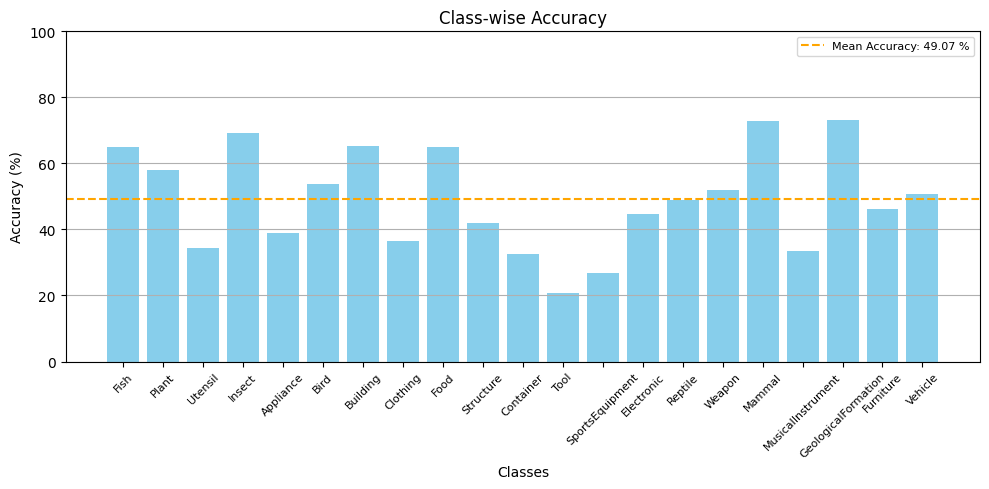

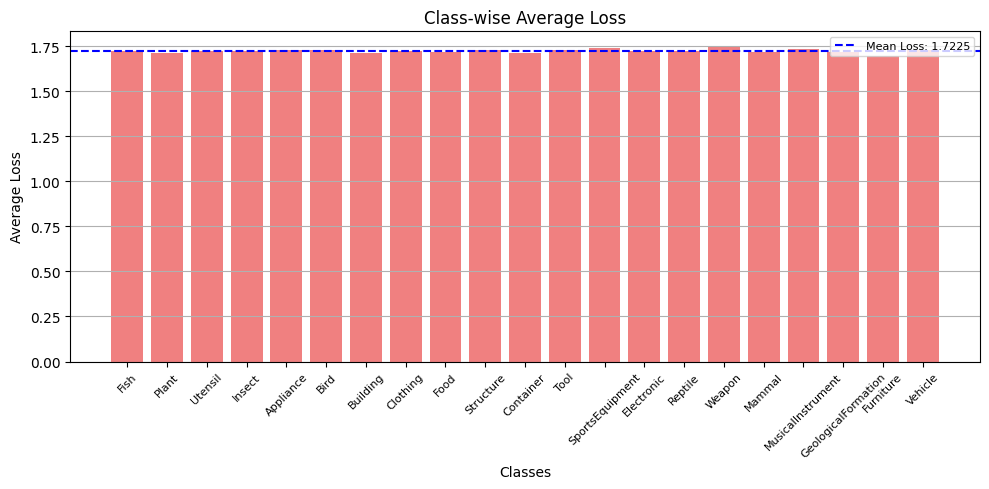

In [ ]:
# 클래스별 정확도 및 총 개수 초기화
class_correct = list(0. for _ in range(len(class_name)))
class_total = list(0. for _ in range(len(class_name)))

# 클래스별 손실 초기화
class_loss = list(0. for _ in range(len(class_name)))
class_count = list(0. for _ in range(len(class_name)))

# 손실 함수 정의
criterion = nn.CrossEntropyLoss()

# 모델 평가
with torch.no_grad():
    total_loss = 0.0  # 전체 손실 초기화
    total_samples = 0  # 전체 샘플 수 초기화
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)

        # 손실 계산
        loss = criterion(outputs, labels)
        total_loss += loss.item() * labels.size(0)  # 전체 손실에 샘플 수를 곱하여 추가
        total_samples += labels.size(0)  # 전체 샘플 수 증가

        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()

        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
            class_loss[label] += loss.item()  # 손실 누적
            class_count[label] += 1  # 클래스별 샘플 수 증가

# 클래스별 정확도 출력
accuracies = []
for i in range(len(class_name)):
    accuracy = 100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0.0
    accuracies.append(accuracy)
    print(f'Accuracy of {class_name[i]} : {accuracy:.2f} %')

# 클래스별 평균 손실 계산
average_losses = []
for i in range(len(class_name)):
    average_loss = class_loss[i] / class_count[i] if class_count[i] > 0 else 0.0
    average_losses.append(average_loss)
    print(f'Average Loss of {class_name[i]} : {average_loss:.4f}')

# 전체 평균 손실 계산
mean_loss = total_loss / total_samples if total_samples > 0 else 0.0
print(f'Mean Loss: {mean_loss:.4f}')

# 평균 정확도 계산
mean_accuracy = sum(accuracies) / len(accuracies)
print(f'Mean Accuracy: {mean_accuracy:.2f} %')

# 정확도 히스토그램
plt.figure(figsize=(10, 5))
plt.bar(class_name, accuracies, color='skyblue')
plt.axhline(y=mean_accuracy, color='orange', linestyle='--', label=f'Mean Accuracy: {mean_accuracy:.2f} %')
plt.xlabel('Classes', fontsize=10)  # X축 레이블 글자 크기 조정
plt.ylabel('Accuracy (%)', fontsize=10)  # Y축 레이블 글자 크기 조정
plt.title('Class-wise Accuracy', fontsize=12)  # 제목 글자 크기 조정
plt.xticks(rotation=45, fontsize=8)  # X축 눈금 글자 크기 조정
plt.ylim(0, 100)
plt.grid(axis='y')
plt.legend(fontsize=8)  # 범례 글자 크기 조정
plt.tight_layout()
plt.show()  # 첫 번째 플롯 표시

# 손실 히스토그램
plt.figure(figsize=(10, 5))
plt.bar(class_name, average_losses, color='lightcoral')
plt.axhline(y=mean_loss, color='blue', linestyle='--', label=f'Mean Loss: {mean_loss:.4f}')  # 평균 손실 추가
plt.xlabel('Classes', fontsize=10)  # X축 레이블 글자 크기 조정
plt.ylabel('Average Loss', fontsize=10)  # Y축 레이블 글자 크기 조정
plt.title('Class-wise Average Loss', fontsize=12)  # 제목 글자 크기 조정
plt.xticks(rotation=45, fontsize=8)  # X축 눈금 글자 크기 조정
plt.grid(axis='y')
plt.legend(fontsize=8)  # 범례 글자 크기 조정
plt.tight_layout()
plt.show()  # 두 번째 플롯 표시


## 비전 트랜스포머 이재현님 데이터전처리

Accuracy of Fish : 67.02 %
Accuracy of Plant : 72.30 %
Accuracy of Utensil : 75.67 %
Accuracy of Insect : 74.19 %
Accuracy of Appliance : 57.74 %
Accuracy of Bird : 82.24 %
Accuracy of Building : 86.76 %
Accuracy of Clothing : 67.87 %
Accuracy of Food : 78.89 %
Accuracy of Structure : 55.89 %
Accuracy of Container : 52.02 %
Accuracy of Tool : 48.55 %
Accuracy of SportsEquipment : 63.48 %
Accuracy of Electronic : 59.30 %
Accuracy of Reptile : 74.58 %
Accuracy of Weapon : 63.53 %
Accuracy of Mammal : 77.58 %
Accuracy of MusicalInstrument : 55.98 %
Accuracy of GeologicalFormation : 80.74 %
Accuracy of Furniture : 56.85 %
Accuracy of Vehicle : 73.21 %
Average Loss of Fish : 1.0596
Average Loss of Plant : 1.0600
Average Loss of Utensil : 1.0635
Average Loss of Insect : 1.0643
Average Loss of Appliance : 1.0674
Average Loss of Bird : 1.0710
Average Loss of Building : 1.0633
Average Loss of Clothing : 1.0694
Average Loss of Food : 1.0582
Average Loss of Structure : 1.0902
Average Loss of Cont

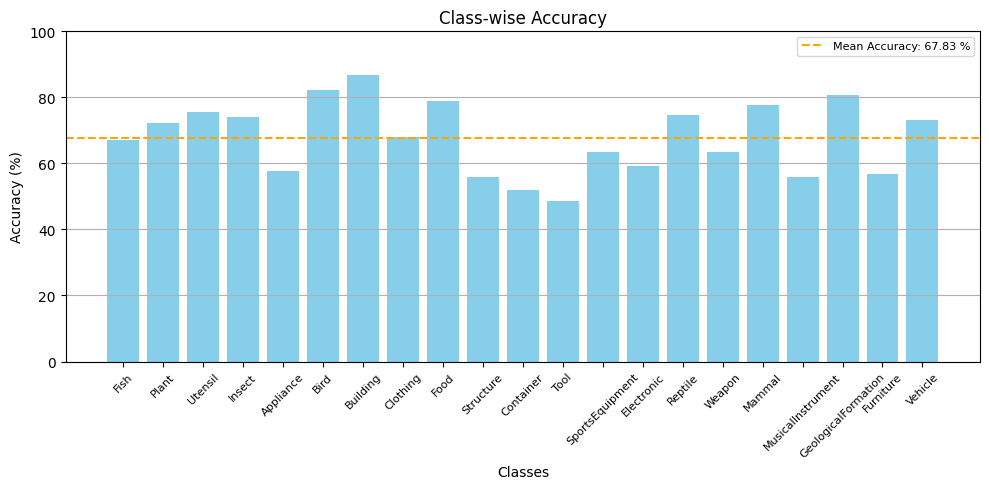

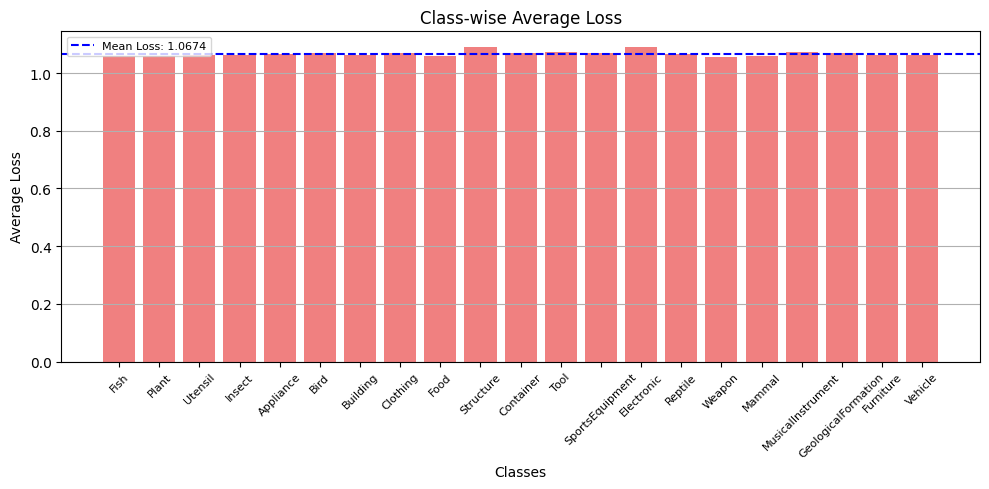

In [ ]:
# 클래스별 정확도 및 총 개수 초기화
class_correct = list(0. for _ in range(len(class_name)))
class_total = list(0. for _ in range(len(class_name)))

# 클래스별 손실 초기화
class_loss = list(0. for _ in range(len(class_name)))
class_count = list(0. for _ in range(len(class_name)))

# 손실 함수 정의
criterion = nn.CrossEntropyLoss()

# 모델 평가
with torch.no_grad():
    total_loss = 0.0  # 전체 손실 초기화
    total_samples = 0  # 전체 샘플 수 초기화
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)

        # 손실 계산
        loss = criterion(outputs, labels)
        total_loss += loss.item() * labels.size(0)  # 전체 손실에 샘플 수를 곱하여 추가
        total_samples += labels.size(0)  # 전체 샘플 수 증가

        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()

        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
            class_loss[label] += loss.item()  # 손실 누적
            class_count[label] += 1  # 클래스별 샘플 수 증가

# 클래스별 정확도 출력
accuracies = []
for i in range(len(class_name)):
    accuracy = 100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0.0
    accuracies.append(accuracy)
    print(f'Accuracy of {class_name[i]} : {accuracy:.2f} %')

# 클래스별 평균 손실 계산
average_losses = []
for i in range(len(class_name)):
    average_loss = class_loss[i] / class_count[i] if class_count[i] > 0 else 0.0
    average_losses.append(average_loss)
    print(f'Average Loss of {class_name[i]} : {average_loss:.4f}')

# 전체 평균 손실 계산
mean_loss = total_loss / total_samples if total_samples > 0 else 0.0
print(f'Mean Loss: {mean_loss:.4f}')

# 평균 정확도 계산
mean_accuracy = sum(accuracies) / len(accuracies)
print(f'Mean Accuracy: {mean_accuracy:.2f} %')

# 정확도 히스토그램
plt.figure(figsize=(10, 5))
plt.bar(class_name, accuracies, color='skyblue')
plt.axhline(y=mean_accuracy, color='orange', linestyle='--', label=f'Mean Accuracy: {mean_accuracy:.2f} %')
plt.xlabel('Classes', fontsize=10)  # X축 레이블 글자 크기 조정
plt.ylabel('Accuracy (%)', fontsize=10)  # Y축 레이블 글자 크기 조정
plt.title('Class-wise Accuracy', fontsize=12)  # 제목 글자 크기 조정
plt.xticks(rotation=45, fontsize=8)  # X축 눈금 글자 크기 조정
plt.ylim(0, 100)
plt.grid(axis='y')
plt.legend(fontsize=8)  # 범례 글자 크기 조정
plt.tight_layout()
plt.show()  # 첫 번째 플롯 표시

# 손실 히스토그램
plt.figure(figsize=(10, 5))
plt.bar(class_name, average_losses, color='lightcoral')
plt.axhline(y=mean_loss, color='blue', linestyle='--', label=f'Mean Loss: {mean_loss:.4f}')  # 평균 손실 추가
plt.xlabel('Classes', fontsize=10)  # X축 레이블 글자 크기 조정
plt.ylabel('Average Loss', fontsize=10)  # Y축 레이블 글자 크기 조정
plt.title('Class-wise Average Loss', fontsize=12)  # 제목 글자 크기 조정
plt.xticks(rotation=45, fontsize=8)  # X축 눈금 글자 크기 조정
plt.grid(axis='y')
plt.legend(fontsize=8)  # 범례 글자 크기 조정
plt.tight_layout()
plt.show()  # 두 번째 플롯 표시


# Make SubmitFile

In [ ]:
save_model(model,'/content/updata_data_vt_16_train_model_25.pth')
load_model(model,'/content/updata_data_vt_16_train_model_25.pth')

Model saved to /content/updata_data_vt_16_train_model_25.pth
Model loaded from /content/updata_data_vt_16_train_model_25.pth


In [ ]:
outputs = {
    'Id': [],
    'Prediction': []
}

for images, id in test_loader:
    model.eval()
    with torch.no_grad():

        output = model(images.to(device))
        _, predicted = torch.max(output, 1)
        outputs['Prediction'] += predicted.tolist()
        outputs['Id'] += id

df = pd.DataFrame(outputs)

df.to_csv('submission.csv', index=False, columns=['Id', 'Prediction'])